In [1]:
# 전체 데이터를 받았을 때
!unzip 2019-2nd-ml-month-with-kakr.zip
!rm test.csv # 길이가 맞지않아 aiffel 에서 제공한 test.csv으로 진행
!mv test_cloud.csv test.csv

Archive:  2019-2nd-ml-month-with-kakr.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
data_dir = './' # local

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
submission_path =  join(data_dir, 'sample_submission.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
submission = pd.read_csv(submission_path)

In [4]:
print(set(train.columns)-set(test.columns)) # train, test 컬럼 비교
train.shape, test.shape, submission.shape # 파일 차원 확인

{'price'}


((15035, 21), (6468, 20), (6468, 2))

In [5]:
len(set(test.id)&set(submission.id)) # 동일 파일 확인

6468

In [6]:
y = train.pop('price') # target y로 빼서 저장
y.shape

(15035,)

In [7]:
train.shape, test.shape

((15035, 20), (6468, 20))

## **1. 결측치 확인**

<Figure size 50x150 with 0 Axes>

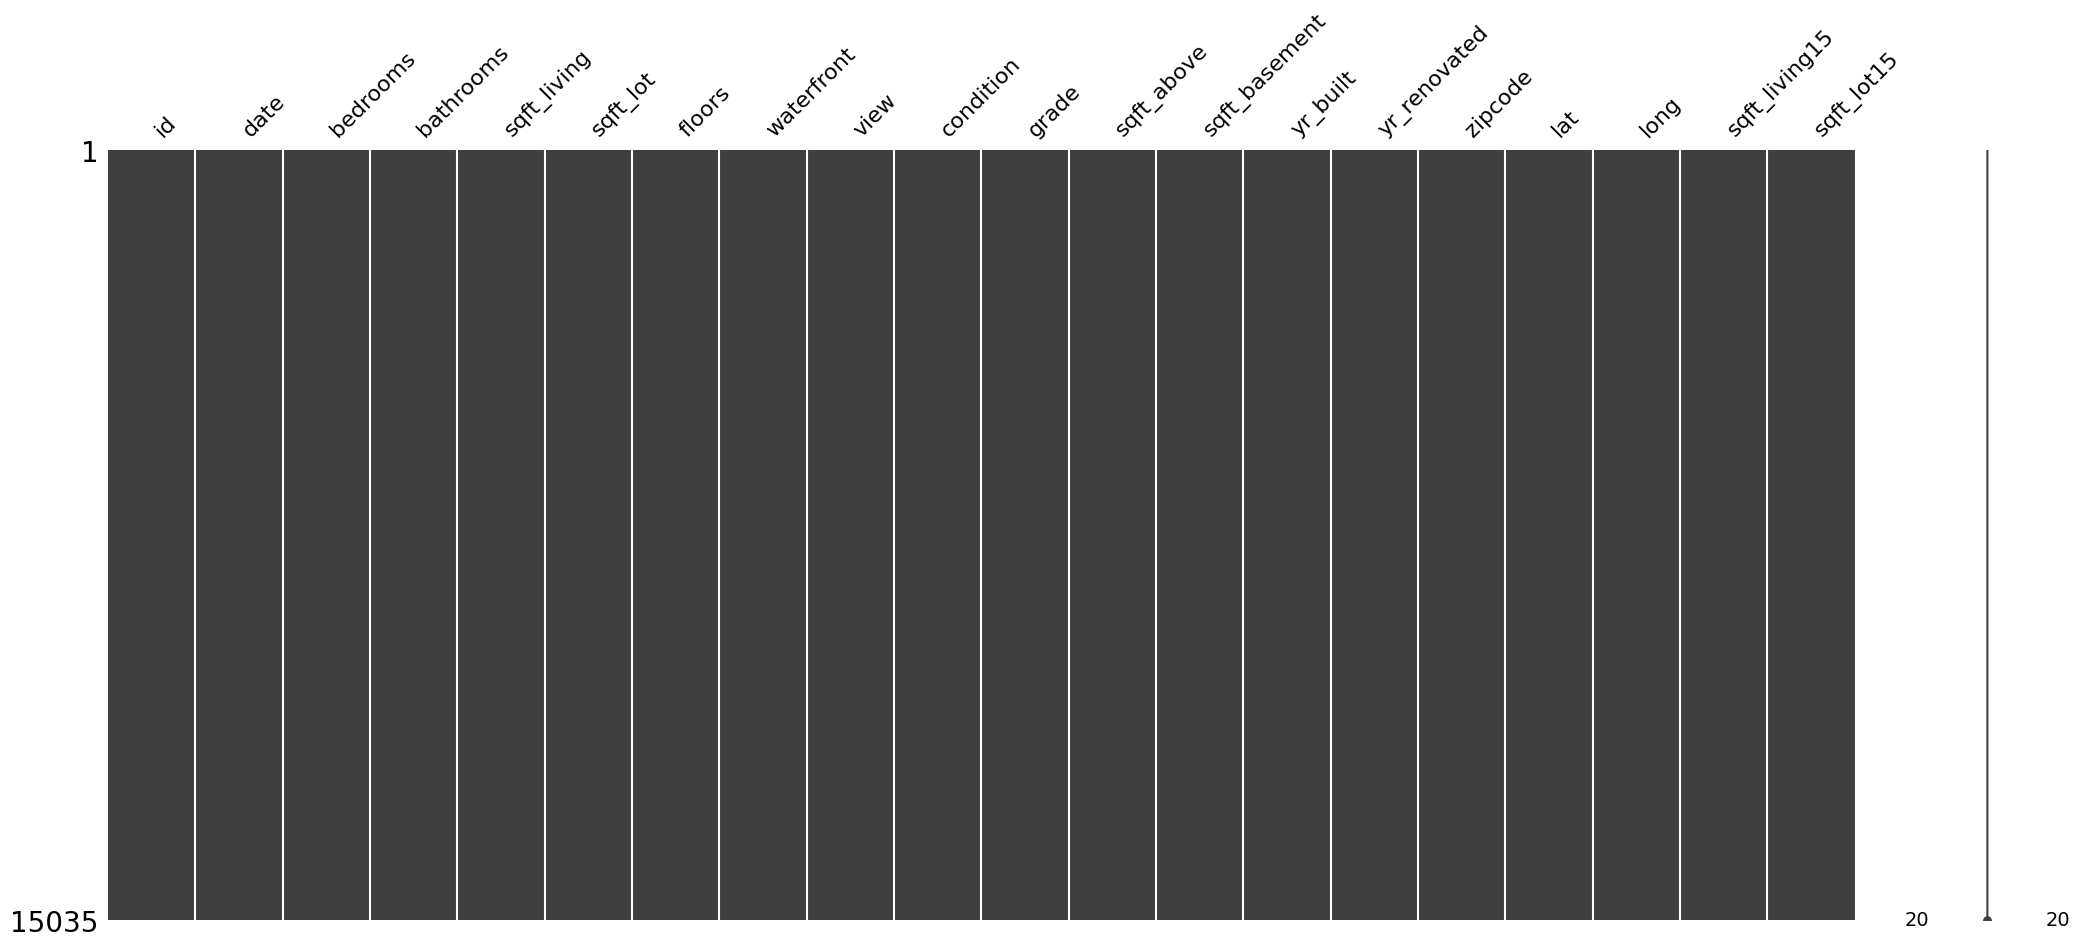

In [8]:
# msno를 통한 데이터 null 확인
plt.figure(figsize = (0.5,1.5))
msno.matrix(train)
plt.show()

In [9]:
print('- NULL value Check -')
print()
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

- NULL value Check -

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## **2. 데이터 전처리**

In [10]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
train['date'] = train['date'].apply(lambda x : int(x[:6])) # 필요없는 부분 삭제
del train['id'] # 필요없는 부분 삭제

test['date'] = test['date'].apply(lambda x: int(x[:6]))  # test도 동일하게 전처리 진행
del test['id']  # test도 동일하게 전처리 진행

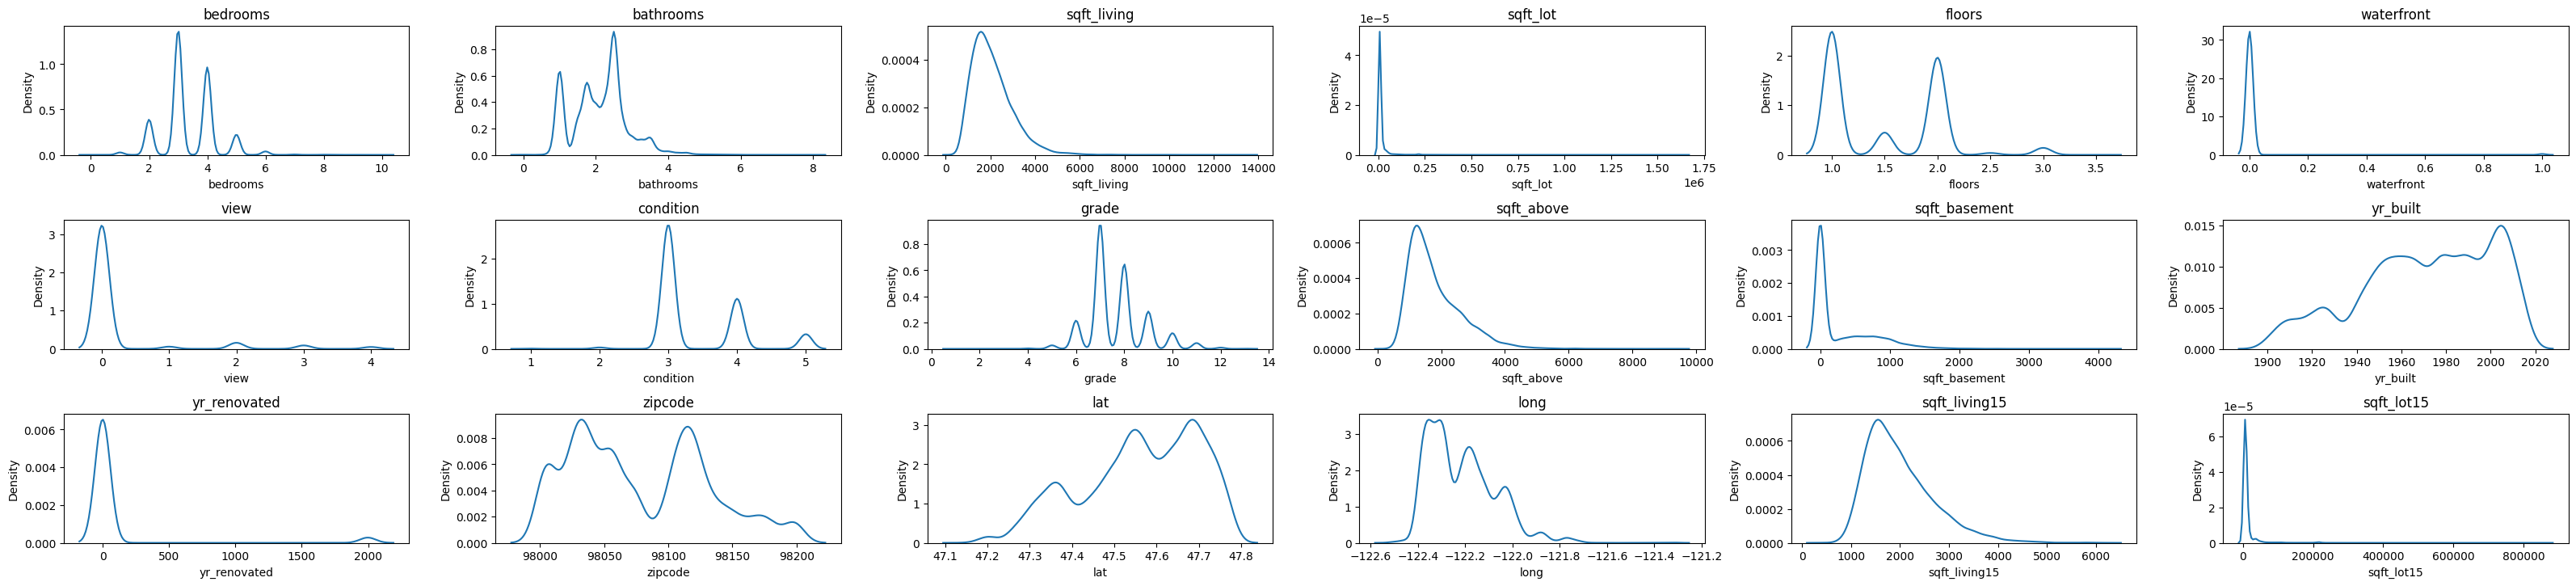

In [13]:
fig, ax = plt.subplots(3, 6, figsize=(40, 8))  # feature 들의 전체적인 값 분포 확인을 위한 그림

count = 1  # date column 확인 필요가 없으므로 1 부터 시작
columns = train.columns
for row in range(3):
    for col in range(6):
      try:
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=12)
        count += 1
        if count == len(columns) :
            break
      except:
        print(columns[count])

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.5)
plt.show()

In [14]:
# 값의 분포가 치우쳐졌거나 수치가 지나치게 큰 값들을 log 변환을 통하여 정규화 효과를 적용시킴
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train['log_'+c] = np.log1p(train[c].values)
    test['log_'+c] = np.log1p(test[c].values)

**Log 변환의 이유**


위 분포는 0 쪽으로 매우 심하게 치우쳐져 있음
즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.

따라서 이 분포에 로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.

즉, 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것이다.

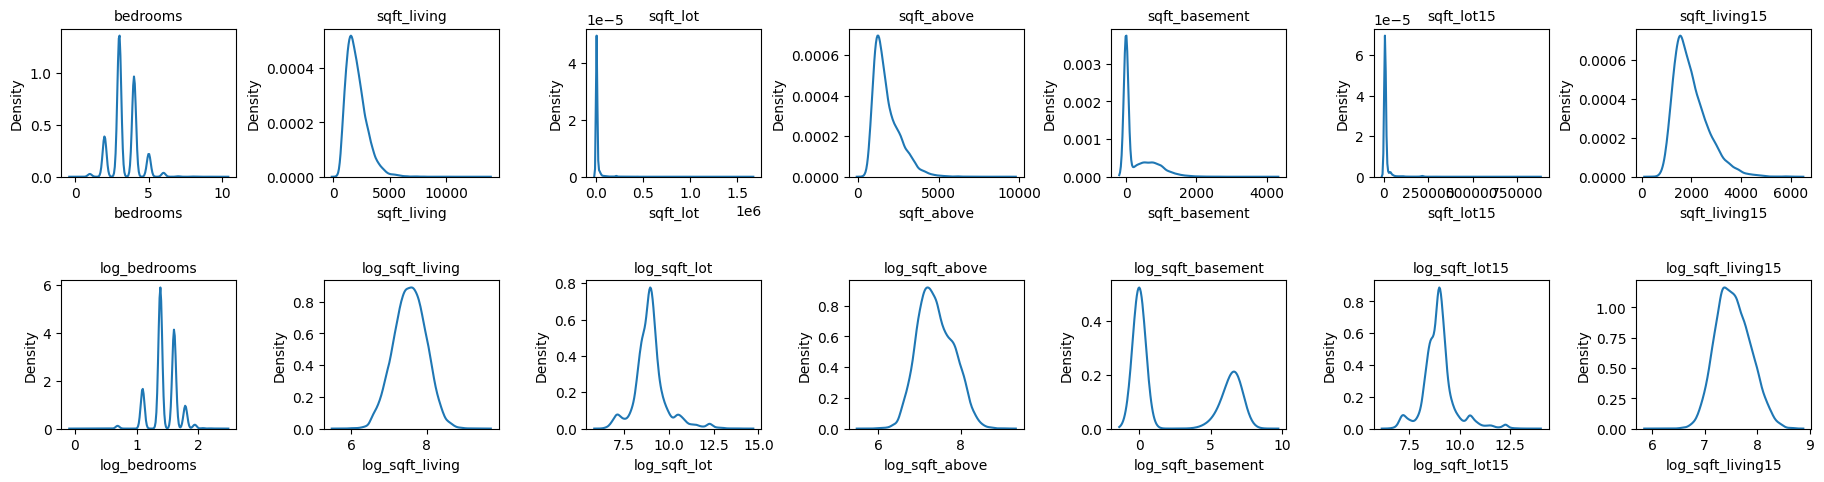

In [15]:
# log 변환 전후 비교 (윗 줄 : before, 아랫줄 : after)

fig, ax = plt.subplots(2, len(skew_columns), figsize=(20, 5))
count = 0
for col in range(len(skew_columns)):
    sns.kdeplot(data=train[skew_columns[count]], ax=ax[0][col])
    ax[0][col].set_title(skew_columns[count], fontsize=10)

    sns.kdeplot(data=train['log_'+skew_columns[count]], ax=ax[1][col])
    ax[1][col].set_title('log_'+skew_columns[count], fontsize=10)
    count += 1
    if count == len(skew_columns) :
        break

plt.subplots_adjust(left=0.125, bottom=0.1, right= 1, top=0.9, wspace=0.5, hspace=0.7)

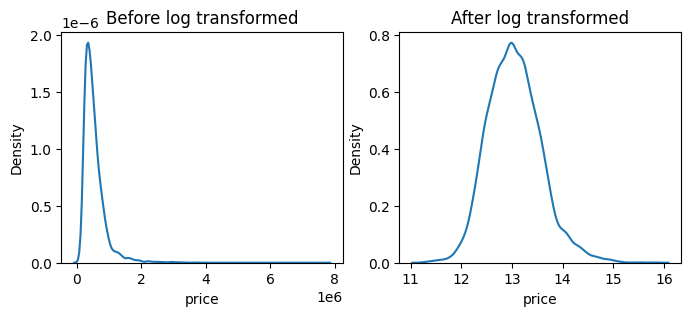

In [35]:
# y 값도 치우치지 않은 값으로 변경시켜 줌으로써 예측 결과가 정규 분포를 따르도록 함 (학습의 용이성을 위해 변경)
plt.figure(figsize = (8,3))
ax1 = plt.subplot(121)
sns.kdeplot(y, ax = ax1)
ax1.set_title('Before log transformed')

y = np.log1p(y)

ax2 = plt.subplot(122)
sns.kdeplot(y, ax = ax2)
ax2.set_title('After log transformed')

plt.show()

In [17]:
# price 가 있는 상황에서 각 feature의 correlation 확인
data = pd.read_csv(train_data_path)
for c in skew_columns:
    data[c] = np.log1p(data[c].values)
data.corr()['price'].sort_values(ascending = False)

price            1.000000
grade            0.667211
sqft_living      0.609857
sqft_living15    0.543531
sqft_above       0.542959
bathrooms        0.525479
view             0.400806
bedrooms         0.311686
lat              0.301604
waterfront       0.265738
floors           0.262588
sqft_basement    0.204640
sqft_lot         0.166851
sqft_lot15       0.150539
yr_renovated     0.140808
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
zipcode         -0.051498
Name: price, dtype: float64

In [18]:
# cols = ['grade','log_sqft_living15','log_sqft_living','log_sqft_above','bathrooms']
# cols = ['grade','log_sqft_living15','log_sqft_living','log_sqft_above','bathrooms','view','log_bedrooms','lat']
# cols = ['grade','log_sqft_living15','log_sqft_living','log_sqft_above','bathrooms','view','log_bedrooms','lat','waterfront','floors']
cols = list(set(train.columns)-set(skew_columns)) # 다 넣었을때가 성능이 가장 좋음, log 변환 전 columns 학습 목록에서 제외시킴

## **3. 학습 및 예측**



In [19]:
random_state=2023   # random seed 설정

**학습을 위한 함수**

In [70]:
def rmse(y_test, y_pred):
  # 손실함수로 RMSE 채택
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


def get_cv_score(models):
  # k-fold cross validation 진행하여 평균 score 산출
  kfold = KFold(n_splits=5).get_n_splits(train.values)
  for model in models:
      CV_score = np.mean(cross_val_score(model, X=train.values, y=y, cv=kfold))
      print(f"Model: {model.__class__.__name__}, CV score:{CV_score:.4f}")


def get_scores(models, train, y):
  # 여러 모델 중 기본적인 성능이 가장 좋은 모델 확인을 위한 함수
  # 결과를 df 형태로 return 받음

  df = {}

  for model in models:
      # 모델 이름 획득
      model_name = model.__class__.__name__

      # train, test 데이터셋 분리
      train_x, test_x, train_y, test_y = train_test_split(train, y,
                                                          test_size = 0.2,
                                                          random_state = random_state )
      # 모델 학습
      model.fit(train_x, train_y)
      # 예측
      pred = model.predict(test_x)
      # 예측 결과의 rmse값 저장
      df[model_name] = rmse(test_y, pred)
      # data frame에 저장
      score_df = pd.DataFrame(df, index=['RMSLE']).T.sort_values('RMSLE', ascending=False)

  return score_df


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  # 특정 모델에 대한 best parameter를 찾기 위한 함수
  # 결과를 df 형태로 return 받음

  gv = GridSearchCV(model, param_grid=param_grid, \
                          scoring='neg_mean_squared_error', \
                          cv=5, verbose=1, n_jobs=5)
  gv.fit(train, y)

  results = pd.DataFrame(gv.cv_results_['params'])
  results['score'] = gv.cv_results_['mean_test_score']

  results['RMSLE'] = results['score'].apply(lambda x:  np.sqrt(-1 * x) )

  return results.sort_values('RMSLE'), gv


**결과 저장을 위한 함수**

In [68]:

def prep_submission(model, gv, res, train, y, test, model_name):
  # best param을 적용하여 학습을 재진행하고 예측 결과를 csv 저장

  print('Best params:', res.iloc[0,:-2].to_dict())
  # 탐색 param에 따라서 함수를 변경해야함
  # model = LGBMRegressor(max_depth= res['max_depth'].iloc[0], n_estimators= res['n_estimators'].iloc[0], num_leaves = res['num_leaves'].iloc[0], learning_rate = res['learning_rate'].iloc[0],random_state=random_state)
  model = LGBMRegressor(random_state = random_state,**gv.best_params_)
  model.fit(train[cols], y)

  prediction = model.predict(test[cols])
  prediction = np.expm1(prediction)

  submission['price'] = prediction

  submission_csv_path = '{}submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', round(res['RMSLE'].iloc[0],3))
  print(submission_csv_path)
  submission.to_csv(submission_csv_path, index=False)


def prep_submission_with_ensemble(models, train, y, test):
  # 여러 모델들의 결과를 평균내어 submission 작성

  res = []
  for i, model in enumerate(models):
    model.fit(train[cols], y)
    pred = model.predict(test[cols])
    res.append(pred)

    print(f'{model.__class__.__name__} prediction completed, {len(models)-i-1} model remained.')

  mean_predict = np.mean(res, axis =0)
  prediction = np.expm1(mean_predict)

  submission['price'] = prediction

  submission_csv_path = '{}submission_{}_ensemble_{}_models.csv'.format(data_dir, 'lgbm', len(models))
  print(submission_csv_path)
  submission.to_csv(submission_csv_path, index=False)

In [36]:
# 각 regression 모델 호출
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
# models = [gboost, xgboost, lightgbm]

In [37]:
get_cv_score(models) # cross validation 성능 확인

Model: GradientBoostingRegressor, CV score:0.8796
Model: XGBRegressor, CV score:0.8960
Model: LGBMRegressor, CV score:0.9025
Model: RandomForestRegressor, CV score:0.8855


In [39]:
get_scores(models, train, y) # RMSE 성능으로 산출 (log scale의 error 라서 RMSLE로 표현됨)

,RMSLE
RandomForestRegressor,140103.317789
GradientBoostingRegressor,127901.879636
XGBRegressor,120604.487640
LGBMRegressor,115213.997594


In [41]:
prep_submission_with_ensemble(models, train, y, test) # 각 모델들의 평균으로 submission 저장해봄

GradientBoostingRegressor prediction completed, 3 model remained.
XGBRegressor prediction completed, 2 model remained.
LGBMRegressor prediction completed, 1 model remained.
RandomForestRegressor prediction completed, 0 model remained.
./submission_lgbm_ensemble_4_models.csv


### Score: 119255.79468 으로 충분히 낮지 않아 특정 모델에 대한 깊은 탐색 시도

In [43]:
# LGBM의 성능이 가장 좋으므로 이에대한 best params 검색

In [65]:
# 여러가지 pramater 설정

# param_grid = {
#     # 'num_leaves': [7, 21, 50],
#     # 'max_depth': [1, 3, 5, 10],
#     # 'n_estimators': [10, 50, 150, 300],
# }

# 좋은 값을 토대로 추가로 변경해가면서 탐색 진

param_grid = {
    'num_leaves':[21],
    'max_depth': [10],
    'n_estimators': [300],
    'learning_rate' : [0.1],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9,],
}


In [71]:
model = LGBMRegressor(random_state=random_state)

res, gv = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
res

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,score,RMSLE
2,0.9,0.1,10,300,21,0.8,-0.026111,0.161589
3,0.9,0.1,10,300,21,0.9,-0.026111,0.161589
0,0.8,0.1,10,300,21,0.8,-0.026275,0.162097
1,0.8,0.1,10,300,21,0.9,-0.026275,0.162097


In [72]:
prep_submission(model, gv, res, train, y, test, 'lgbm')

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10.0, 'n_estimators': 300.0, 'num_leaves': 21.0, 'subsample': 0.8}
./submission_lgbm_RMSLE_0.162.csv


### Score: 112292.95279 으로 떨어졌으므로 다른 parameter 들에 대한 추가 탐색을 통해 개선을 해야함